# Assignment 3: Function Approximation and Control

Welcome to Assignment 3. In this notebook you will learn how to:
- Use function approximation in the control setting
- Implement the Sarsa algorithm using tile coding
- Compare three settings for tile coding to see their effect on our agent

As with the rest of the notebooks do not import additional libraries or adjust grading cells as this will break the grader.

MAKE SURE TO RUN ALL OF THE CELLS SO THE GRADER GETS THE OUTPUT IT NEEDS


In [2]:
# Import Necessary Libraries
import numpy as np
import matplotlib.pyplot as plt
import tiles3 as tc
from rl_glue import RLGlue
from agent import BaseAgent
from utils import argmax
import mountaincar_env
import time

In the above cell, we import the libraries we need for this assignment. You may have noticed that we import mountaincar_env. This is the __Mountain Car Task__ introduced in [Section 10.1 of the textbook](http://www.incompleteideas.net/book/RLbook2018.pdf#page=267). The task is for an under powered car to make it to the top of a hill:
![Mountain Car](mountaincar.png "Mountain Car")
The car is under-powered so the agent needs to learn to rock back and forth to get enough momentum to reach the goal. At each time step the agent receives from the environment its current velocity (a float between -0.07 and 0.07), and it's current position (a float between -1.2 and 0.5). Because our state is continuous there are a potentially infinite number of states that our agent could be in. We need a function approximation method to help the agent deal with this. In this notebook we will use tile coding. We provide a tile coding implementation for you to use, imported above with tiles3.

## Section 0: Tile Coding Helper Function

To begin we are going to build a tile coding class for our Sarsa agent that will make it easier to make calls to our tile coder.

### Tile Coding Function

Tile coding is introduced in [Section 9.5.4 of the textbook](http://www.incompleteideas.net/book/RLbook2018.pdf#page=239) of the textbook as a way to create features that can both provide good generalization and discrimination. It consists of multiple overlapping tilings, where each tiling is a partitioning of the space into tiles.
![Tile Coding](tilecoding.png "Tile Coding")

To help keep our agent code clean we are going to make a function specific for tile coding for our Mountain Car environment. To help we are going to use the Tiles3 library. This is a Python 3 implementation of the tile coder. To start take a look at the documentation: [Tiles3 documentation](http://incompleteideas.net/tiles/tiles3.html)
To get the tile coder working we need to implement a few pieces:
- First: create an index hash table - this is done for you in the init function using tc.IHT.
- Second is to scale the inputs for the tile coder based on the number of tiles and the range of values each input could take. The tile coder needs to take in a number in range [0, 1], or scaled to be [0, 1] * num_tiles. For more on this refer to the [Tiles3 documentation](http://incompleteideas.net/tiles/tiles3.html).
- Finally we call tc.tiles to get the active tiles back.

In [3]:
# Tile Coding Function [Graded]
class MountainCarTileCoder:
    def __init__(self, iht_size=4096, num_tilings=8, num_tiles=8):
        """
        Initializes the MountainCar Tile Coder
        Initializers:
        iht_size -- int, the size of the index hash table, typically a power of 2
        num_tilings -- int, the number of tilings
        num_tiles -- int, the number of tiles. Here both the width and height of the
                     tile coder are the same
        Class Variables:
        self.iht -- tc.IHT, the index hash table that the tile coder will use
        self.num_tilings -- int, the number of tilings the tile coder will use
        self.num_tiles -- int, the number of tiles the tile coder will use
        """
        self.iht = tc.IHT(iht_size)
        self.num_tilings = num_tilings
        self.num_tiles = num_tiles
    
    def get_tiles(self, position, velocity):
        """
        Takes in a position and velocity from the mountaincar environment
        and returns a numpy array of active tiles.
        
        Arguments:
        position -- float, the position of the agent between -1.2 and 0.5
        velocity -- float, the velocity of the agent between -0.07 and 0.07
        returns:
        tiles - np.array, active tiles
        """
        # Set the max and min of position and velocity to scale the input
        # POSITION_MIN
        # POSITION_MAX
        # VELOCITY_MIN
        # VELOCITY_MAX
        ### START CODE HERE ###
        POSITION_MIN=-1.2
        POSITION_MAX=0.5
        VELOCITY_MIN=-0.07
        VELOCITY_MAX=0.07
        ### END CODE HERE ###
        
        # Use the ranges above and self.num_tiles to set position_scale and velocity_scale
        # position_scale = number of tiles / position range
        # velocity_scale = number of tiles / velocity range
        
        # Scale position and velocity by multiplying the inputs of each by their scale
        
        ### START CODE HERE ###
        position_scale = self.num_tiles/(POSITION_MAX-POSITION_MIN)
        velocity_scale = self.num_tiles/(VELOCITY_MAX-VELOCITY_MIN)
        ### END CODE HERE ###
        
        # get the tiles using tc.tiles, with self.iht, self.num_tilings and [scaled position, scaled velocity]
        # nothing to implment here
        tiles = tc.tiles(self.iht, self.num_tilings, [position * position_scale, 
                                                      velocity * velocity_scale])
        
        return np.array(tiles)

In [4]:
# [DO NOT CHANGE]
tests = [[-1.0, 0.01], [0.1, -0.01], [0.2, -0.05], [-1.0, 0.011], [0.2, -0.05]]

mctc = MountainCarTileCoder(iht_size=1024, num_tilings=8, num_tiles=8)

t = []
for test in tests:
    position, velocity = test
    tiles = mctc.get_tiles(position=position, velocity=velocity)
    t.append(tiles)

print("Your results:")
for tiles in t:
    print(tiles)

print()
print("Expected results:")
expected = """[0 1 2 3 4 5 6 7]
[ 8  9 10 11 12 13 14 15]
[16 17 18 19 20 21 22 23]
[ 0 24  2  3  4  5  6  7]
[16 17 18 19 20 21 22 23]
"""
print(expected)

np.random.seed(1)
mctc_test = MountainCarTileCoder(iht_size=1024, num_tilings=8, num_tiles=8)
test = [mctc_test.get_tiles(np.random.uniform(-1.2, 0.5), np.random.uniform(-0.07, 0.07)) for _ in range(10)]
np.save("tiles_test", test)

Your results:
[0 1 2 3 4 5 6 7]
[ 8  9 10 11 12 13 14 15]
[16 17 18 19 20 21 22 23]
[ 0 24  2  3  4  5  6  7]
[16 17 18 19 20 21 22 23]

Expected results:
[0 1 2 3 4 5 6 7]
[ 8  9 10 11 12 13 14 15]
[16 17 18 19 20 21 22 23]
[ 0 24  2  3  4  5  6  7]
[16 17 18 19 20 21 22 23]



## Section 1: Sarsa Agent

We are now going to use the functions that we just created to implement the Sarsa algorithm. Recall from class that Sarsa stands for State, Action, Reward, State, Action.

For this case we have given you an argmax function similar to what you wrote back in Course 1 Assignment 1. Recall, this is different than the argmax function that is used by numpy, which returns the first index of a maximum value. We want our argmax function to arbitrarily break ties, which is what the imported argmax function does. The given argmax function takes in an array of values and returns an int of the chosen action: 
argmax(action values)

There are multiple ways that we can deal with actions for the tile coder. Here we are going to use one simple method - make the size of the weight vector equal to (iht_size, num_actions). This will give us one weight vector for each action and one weight for each tile.

Use the above function to help fill in select_action, agent_start, agent_step, and agent_end.

Hints:

1) The tile coder returns a list of active indexes (e.g. [1, 12, 22]). You can index a numpy array using an array of values - this will return an array of the values at each of those indices. So in order to get the value of a state we can index our weight vector using the action and the array of tiles that the tile coder returns:

```self.w[action][active_tiles]```

This will give us an array of values, one for each active tile, and we sum the result to get the value of that state-action pair.

2) In the case of a binary feature vector (such as the tile coder), the derivative is 1 at each of the active tiles, and zero otherwise.

In [19]:
# SARSA
class SarsaAgent(BaseAgent):
    """
    Initialization of Sarsa Agent. All values are set to None so they can
    be initialized in the agent_init method.
    """
    def __init__(self):
        self.last_action = None
        self.last_state = None
        self.epsilon = None
        self.gamma = None
        self.iht_size = None
        self.w = None
        self.alpha = None
        self.num_tilings = None
        self.num_tiles = None
        self.mctc = None
        self.initial_weights = None
        self.num_actions = None
        self.previous_tiles = None

    def agent_init(self, agent_info={}):
        """Setup for the agent called when the experiment first starts."""
        self.num_tilings = agent_info.get("num_tilings", 8)
        self.num_tiles = agent_info.get("num_tiles", 8)
        self.iht_size = agent_info.get("iht_size", 4096)
        self.epsilon = agent_info.get("epsilon", 0.0)
        self.gamma = agent_info.get("gamma", 1.0)
        self.alpha = agent_info.get("alpha", 0.5) / self.num_tilings
        self.initial_weights = agent_info.get("initial_weights", 0.0)
        self.num_actions = agent_info.get("num_actions", 3)
        
        # We initialize self.w to three times the iht_size. Recall this is because
        # we need to have one set of weights for each action.
        self.w = np.ones((self.num_actions, self.iht_size)) * self.initial_weights
        
        # We initialize self.mctc to the mountaincar verions of the 
        # tile coder that we created
        self.tc = MountainCarTileCoder(iht_size=self.iht_size, 
                                         num_tilings=self.num_tilings, 
                                         num_tiles=self.num_tiles)

    def select_action(self, tiles):
        """
        Selects an action using epsilon greedy
        Args:
        tiles - np.array, an array of active tiles
        Returns:
        (chosen_action, action_value) - (int, float), tuple of the chosen action
                                        and it's value
        """
        action_values = []
        chosen_action = None
        
        # First loop through the weights of each action and populate action_values
        # with the action value for each action and tiles instance
        
        # Use np.random.random to decide if an exploritory action should be taken
        # and set chosen_action to a random action if it is
        # Otherwise choose the greedy action using the given argmax 
        # function and the action values (don't use numpy's armax)
        
        ### START CODE HERE ###
        action_values=np.zeros(self.num_actions)
        for action in range(self.num_actions):
            action_values[action]=np.sum(self.w[action][tiles])
        
        if np.random.random()>self.epsilon:
            chosen_action=argmax(action_values)
        else:
            chosen_action=np.random.randint(0, self.num_actions)       
        ### END CODE HERE ###
        
        return chosen_action, action_values[chosen_action]
    
    def agent_start(self, state):
        """The first method called when the experiment starts, called after
        the environment starts.
        Args:
            state (Numpy array): the state observation from the
                environment's evn_start function.
        Returns:
            The first action the agent takes.
        """
        position, velocity = state
        
        # Use self.tc to set active_tiles using position and velocity
        # set current_action to the epsilon greedy chosen action using
        # the select_action function above with the active tiles
        
        ### START CODE HERE ###
        active_tiles=self.tc.get_tiles(position, velocity)
        current_action, action_value=self.select_action(active_tiles)
        ### END CODE HERE ###
        
        self.last_action = current_action
        self.previous_tiles = np.copy(active_tiles)
        return self.last_action

    def agent_step(self, reward, state):
        """A step taken by the agent.
        Args:
            reward (float): the reward received for taking the last action taken
            state (Numpy array): the state observation from the
                environment's step based, where the agent ended up after the
                last step
        Returns:
            The action the agent is taking.
        """
        # choose the action here
        position, velocity = state
        
        # Use self.tc to set active_tiles using position and velocity
        # set current_action and action_value to the epsilon greedy chosen action using
        # the select_action function above with the active tiles
        
        # Update self.w at self.previous_tiles and self.previous action
        # using the reward, action_value, self.gamma, self.w,
        # self.alpha, and the Sarsa update from the textbook
        
        ### START CODE HERE ###
        active_tiles=self.tc.get_tiles(position, velocity)
        current_action, action_value=self.select_action(active_tiles)
        
        last_action_value=np.sum(self.w[self.last_action][self.previous_tiles])
        self.w[self.last_action][self.previous_tiles]+=self.alpha*(reward+self.gamma*action_value-last_action_value)*1
        ### END CODE HERE ###
        
        self.last_action = current_action
        self.previous_tiles = np.copy(active_tiles)
        return self.last_action

    def agent_end(self, reward):
        """Run when the agent terminates.
        Args:
            reward (float): the reward the agent received for entering the
                terminal state.
        """
        # Update self.w at self.previous_tiles and self.previous action
        # using the reward, self.gamma, self.w,
        # self.alpha, and the Sarsa update from the textbook
        # Hint - there is no action_value used here because this is the end
        # of the episode.
        
        ### START CODE HERE ###
        last_action_value=np.sum(self.w[self.last_action][self.previous_tiles])
        self.w[self.last_action][self.previous_tiles]+=self.alpha*(reward-last_action_value)*1
        ### END CODE HERE ###
     
    def agent_cleanup(self):
        """Cleanup done after the agent ends."""
        pass

    def agent_message(self, message):
        """A function used to pass information from the agent to the experiment.
        Args:
            message: The message passed to the agent.
        Returns:
            The response (or answer) to the message.
        """
        pass

In [20]:
# Test Epsilon Greedy Function [DO NOT CHANGE]
agent = SarsaAgent()
agent.agent_init({"epsilon": 0.1})
agent.w = np.array([np.array([1, 2, 3]), np.array([4, 5, 6]), np.array([7, 8, 9])])

total = 0
for i in range(1000):
    chosen_action, action_value = agent.select_action(np.array([0,1]))
    total += action_value
print(total)
assert total < 15000, "Check that you are not always choosing the best action"

np.save("epsilon_test", total)

agent = SarsaAgent()
agent.agent_init({"epsilon": 0.0})
agent.w = np.array([np.array([1, 2, 3]), np.array([4, 5, 6]), np.array([7, 8, 9])])

chosen_action, action_value = agent.select_action(np.array([0,1]))
print("Expected value")
print("(2, 15)")

print("Your value")
print((chosen_action, action_value))

np.save("egreedy_test", (chosen_action, action_value))

14550.0
Expected value
(2, 15)
Your value
(2, 15.0)


RUN: 0
RUN: 5
Run time: 9.450295686721802


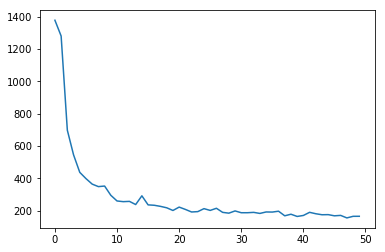

In [21]:
# Test Sarsa Agent [DO NOT CHANGE]
num_runs = 10
num_episodes = 50
env_info = {"num_tiles": 8, "num_tilings": 8}
agent_info = {}
all_steps = []

agent = SarsaAgent
env = mountaincar_env.Environment
start = time.time()

for run in range(num_runs):
    if run % 5 == 0:
        print("RUN: {}".format(run))

    rl_glue = RLGlue(env, agent)
    rl_glue.rl_init(agent_info, env_info)
    steps_per_episode = []

    for episode in range(num_episodes):
        rl_glue.rl_episode(15000)
        steps_per_episode.append(rl_glue.num_steps)

    all_steps.append(np.array(steps_per_episode))

print("Run time: {}".format(time.time() - start))

plt.plot(np.mean(np.array(all_steps), axis=0))
np.save("sarsa_test", np.array(all_steps))

The learning rate of your agent should look similar to ours, though it will not look exactly the same.If there are some spikey points that is okay. Due to stochasticity,  a few episodes may have taken much longer, causing some spikes in the plot. The trend of the line should be similar, though, generally decreasing to about 200 steps per run.
![alt text](sarsa_agent_initial.png "Logo Title Text 1")

This result was using 8 tilings with 8x8 tiles on each. Let's see if we can do better, and what different tilings look like. We will also text 2 tilings of 16x16 and 4 tilings of 32x32. These three choices produce the same number of features (512), but distributed quite differently. 

RUN: 0
RUN: 5
RUN: 10
RUN: 15
0.25
Run Time: 48.52969169616699
RUN: 0
RUN: 5
RUN: 10
RUN: 15
0.015625
Run Time: 30.635058164596558
RUN: 0
RUN: 5
RUN: 10
RUN: 15
0.0625
Run Time: 29.382584810256958


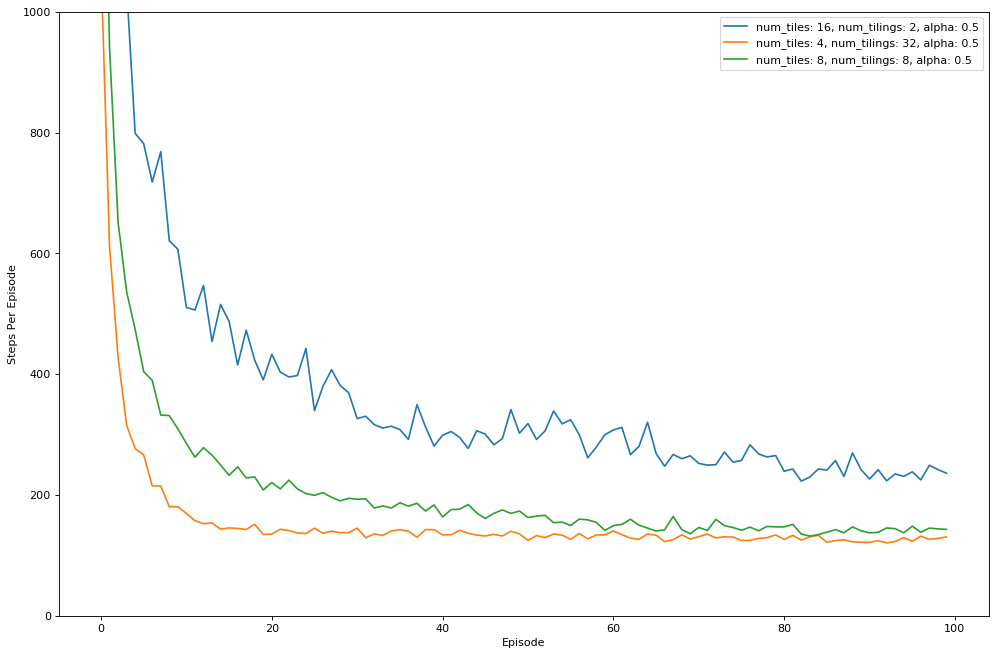

In [22]:
# Compare the three
num_runs = 20
num_episodes = 100
env_info = {}

agent_runs = []
# alphas = [0.2, 0.4, 0.5, 1.0]
alphas = [0.5]
agent_info_options = [{"num_tiles": 16, "num_tilings": 2, "alpha": 0.5},
                      {"num_tiles": 4, "num_tilings": 32, "alpha": 0.5},
                      {"num_tiles": 8, "num_tilings": 8, "alpha": 0.5}]
agent_info_options = [{"num_tiles" : agent["num_tiles"], 
                       "num_tilings": agent["num_tilings"],
                       "alpha" : alpha} for agent in agent_info_options for alpha in alphas]

agent = SarsaAgent
env = mountaincar_env.Environment
for agent_info in agent_info_options:
    all_steps = []
    start = time.time()
    for run in range(num_runs):
        if run % 5 == 0:
            print("RUN: {}".format(run))
        env = mountaincar_env.Environment
        
        rl_glue = RLGlue(env, agent)
        rl_glue.rl_init(agent_info, env_info)
        steps_per_episode = []

        for episode in range(num_episodes):
            rl_glue.rl_episode(15000)
            steps_per_episode.append(rl_glue.num_steps)
        all_steps.append(np.array(steps_per_episode))
    
    agent_runs.append(np.mean(np.array(all_steps), axis=0))
    print(rl_glue.agent.alpha)
    print("Run Time: {}".format(time.time() - start))

plt.figure(figsize=(15, 10), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(np.array(agent_runs).T)
plt.xlabel("Episode")
plt.ylabel("Steps Per Episode")
plt.yscale("linear")
plt.ylim(0, 1000)
plt.legend(["num_tiles: {}, num_tilings: {}, alpha: {}".format(agent_info["num_tiles"], 
                                                               agent_info["num_tilings"],
                                                               agent_info["alpha"])
            for agent_info in agent_info_options])

Here we can see that using 32 tilings and 4 x 4 tiles does a little better than 8 tilings with 8x8 tiles. Both seem to do much better than using 2 tilings, with 16 x 16 tiles.

## Section 3: Conclusion

Congratulations! You have learned how to implement a control agent using function approximation. In this notebook you learned how to:

- Use function approximation in the control setting
- Implement the Sarsa algorithm using tile coding
- Compare three settings for tile coding to see their effect on our agent